# Ejercicio 0: Generación de Datos Sintéticos

In [54]:
import uuid
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Helper functions
def random_date(start_date, end_date, bias_towards_later=False):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    delta = end - start

    if bias_towards_later:
        # Increasing chance for later dates
        days = np.random.beta(a=2, b=5) * delta.days
    else:
        days = random.uniform(0, delta.days)

    return start + timedelta(days=int(days))

def generate_dataset(rows):
    data = []
    for _ in range(rows):
        price = round(random.uniform(1.0, 500.0), 2)
        discount = round(max(0.0, min(0.3, 0.3 - price / 500.0 * random.uniform(0.5, 1.5))), 2)
        region = random.choices(['North', 'South', 'East', 'West'], weights=[0.4, 0.2, 0.2, 0.2])[0]
        shipping_priority = random.choices(['High', 'Medium', 'Low'], weights=[0.6, 0.3, 0.1] if region == 'North' else [0.3, 0.5, 0.2])[0]

        data.append({
            "order_id": str(uuid.uuid4()),
            "customer_id": random.randint(1, 10_000),
            "product_id": random.randint(1, 1_000),
            "quantity": random.randint(1, 20),
            "price": price,
            "discount": discount,
            "order_date": random_date("2023-01-01", "2024-12-31", bias_towards_later=True).strftime("%Y-%m-%d"),
            "shipping_priority": shipping_priority,
            "region": region
        })
    return pd.DataFrame(data)

def introduce_noise(dataframe, noise_fraction):
    num_rows = int(len(dataframe) * noise_fraction)
    rows_with_noise = random.sample(range(len(dataframe)), num_rows)

    for row in rows_with_noise:
        num_columns = random.randint(3, len(dataframe.columns))
        columns_with_noise = random.sample(dataframe.columns.tolist(), num_columns)

        for column in columns_with_noise:
            noise_type = random.choice(["missing", "null", "extreme"])
            if noise_type == "missing":
                dataframe.at[row, column] = np.nan
            elif noise_type == np.nan:
                dataframe.at[row, column] = np.nan
            elif noise_type == "extreme":
                if dataframe[column].dtype in [np.float64, np.int64]:
                    dataframe.at[row, column] = -9999
    return dataframe

# Generate dataset
data = generate_dataset(50_000)

# Introduce noise and missing values
data_noisy = introduce_noise(data, noise_fraction=0.05)


In [26]:
data_noisy

,order_id,customer_id,product_id,quantity,price,discount,order_date,shipping_priority,region
0,a768a45a-420d-47f2-b892-a221affb1a07,5913.0,553.0,14.0,432.98,0.00,2023-07-16,Low,North
1,ee703b43-84bb-4d20-8d51-e945b82cc913,6594.0,222.0,3.0,103.48,0.18,2023-04-06,High,North
2,24e42d63-c54d-4deb-b326-5f32708185a3,2988.0,135.0,5.0,44.67,0.19,2024-01-26,High,West
3,abe9c0dc-a3e1-4dda-8a9d-bd40ae377c98,6936.0,329.0,1.0,387.52,0.00,2023-08-30,High,South
4,cd58df93-5451-4219-887e-b97e4a1d47a7,4406.0,698.0,9.0,427.70,0.00,2023-06-13,Medium,East
...,...,...,...,...,...,...,...,...,...
49995,f699f2ac-c7d5-418e-8e0a-7f3e43ddfa6c,1804.0,607.0,10.0,302.96,0.00,2023-03-08,High,East
49996,f337ed81-c96e-46a7-832f-b56172707eb8,2997.0,385.0,6.0,298.07,0.00,2023-03-26,Medium,South
49997,3426ce89-098a-40da-b233-e4bffbe1e696,5668.0,641.0,7.0,305.37,0.00,2023-08-18,Medium,South
49998,15f58373-53ef-4468-b3ce-af29a3d5ee7a,6690.0,888.0,11.0,36.50,0.24,2023-11-18,Medium,North


In [20]:
# Save to CSV
data_noisy.to_csv("raw_sales_data.csv", index=False)
print("Dataset generated and saved to 'raw_sales_data.csv'")

Dataset generated and saved to 'raw_sales_data.csv'


# Ejercicio 1: Procesamiento de Datos

In [59]:
data_noisy = pd.read_csv('raw_sales_data.csv')

numerical_cols = data_noisy.select_dtypes(include=['float64', 'int64']).columns

# Imputar solo las columnas numéricas
data_noisy[numerical_cols] = data_noisy[numerical_cols].fillna(data_noisy[numerical_cols].mean())

data_noisy['shipping_priority'].fillna(data_noisy['shipping_priority'].mode()[0], inplace=True)  # Imputación con la moda para categóricas

# 2. Identificar valores fuera de rango y corregir
data_noisy = data_noisy[data_noisy['price'] >= 0]  # Eliminar registros con precios negativos
data_noisy = data_noisy[data_noisy['quantity'] >= 0]  # Eliminar registros con cantidades negativas

# 3. Imputación dinámica para 'price' basado en productos similares
# Aquí se asumirá que tenemos una columna 'category' que nos permita agrupar productos similares
data_noisy['price'] = data_noisy.groupby('product_id')['price'].transform(lambda x: x.fillna(x.mean()))

# 4. Calcular ingreso total por cliente
data_noisy['total_income'] = data_noisy['price'] * data_noisy['quantity'] * (1 - data_noisy['discount'])

# 5. Producto más vendido por región
sales_per_region_product = data_noisy.groupby(['region', 'product_id']).agg({'quantity': 'sum'}).reset_index()
most_sold_product_by_region = sales_per_region_product.loc[sales_per_region_product.groupby('region')['quantity'].idxmax()]

# 6. Ingreso total generado por cada región
total_income_by_region = data_noisy.groupby('region').agg({'total_income': 'sum'}).reset_index()

# 7. Distribución de prioridad de envío por región
shipping_priority_distribution = data_noisy.groupby(['region', 'shipping_priority']).agg({'quantity': 'sum'}).reset_index()




C:\Users\E2P7R2U4\AppData\Local\Temp\ipykernel_28592\2147980534.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_noisy['shipping_priority'].fillna(data_noisy['shipping_priority'].mode()[0], inplace=True)  # Imputación con la moda para categóricas


In [60]:
# Save to CSV
data_noisy.to_csv("cleaned_sales_data.csv", index=False)
print("Dataset generated and saved to 'cleaned_sales_data.csv'")

Dataset generated and saved to 'cleaned_sales_data.csv'


# Ejercicio 2: Análisis con SQL

In [44]:

# Conectar (o crear) la base de datos SQLite
conexion = sqlite3.connect('mi_base_de_datos.db')  # El archivo .db se crea automáticamente

# Guardar el DataFrame en SQLite
data_noisy.to_sql('mi_tabla', conexion, if_exists='replace', index=False)

# Cerrar la conexión (opcional, pero recomendado)
conexion.close()

print("Base de datos creada y tabla importada desde el CSV.")

Base de datos creada y tabla importada desde el CSV.


In [ ]:
# Reconectar para realizar consultas
conexion = sqlite3.connect('mi_base_de_datos.db')

# Consulta de ejemplo
query = "SELECT * FROM mi_tabla"
resultado = pd.read_sql_query(query, conexion)

# Mostrar el resultado
print(resultado)

                               order_id  customer_id  product_id  quantity  \
0  a768a45a-420d-47f2-b892-a221affb1a07       5913.0       553.0      14.0   
1  ee703b43-84bb-4d20-8d51-e945b82cc913       6594.0       222.0       3.0   
2  24e42d63-c54d-4deb-b326-5f32708185a3       2988.0       135.0       5.0   
3  abe9c0dc-a3e1-4dda-8a9d-bd40ae377c98       6936.0       329.0       1.0   
4  cd58df93-5451-4219-887e-b97e4a1d47a7       4406.0       698.0       9.0   

    price  discount  order_date shipping_priority region  total_income  
0  432.98      0.00  2023-07-16               Low  North     6061.7200  
1  103.48      0.18  2023-04-06              High  North      254.5608  
2   44.67      0.19  2024-01-26              High   West      180.9135  
3  387.52      0.00  2023-08-30              High  South      387.5200  
4  427.70      0.00  2023-06-13            Medium   East     3849.3000  


## 1.1 Calcular el ingreso total por cliente, ordenado de mayor a menor

In [48]:
query = """SELECT 
    customer_id, 
    SUM(total_income) AS total_income
FROM 
    mi_tabla
GROUP BY 
    customer_id
ORDER BY 
    total_income DESC;
"""
resultado = pd.read_sql_query(query, conexion)

resultado

,customer_id,total_income
0,-9999.000000,1.316879e+09
1,4854.810113,9.628937e+08
2,9876.000000,8.585610e+07
3,5130.000000,7.765526e+07
4,8723.000000,7.593474e+07
...,...,...
9910,2889.000000,4.054820e+01
9911,1153.000000,3.802500e+01
9912,5057.000000,3.166920e+01
9913,9583.000000,2.882600e+00


## 1.2 Encontrar el producto más vendido en cada región considerando el volumen total (quantity * price)

In [51]:
query = """SELECT 
        region,
        product_id,
        SUM(quantity * price) AS total_volume
    FROM 
        mi_tabla
    GROUP BY 
        region, product_id


"""
resultado_2 = pd.read_sql_query(query, conexion)

resultado_2

,region,product_id,total_volume
0,None,-9999.0,91112.630480
1,None,4.0,812.516710
2,None,20.0,215.700000
3,None,48.0,7839.600000
4,None,56.0,947.936161
...,...,...,...
4132,West,996.0,15752.300000
4133,West,997.0,11143.820000
4134,West,998.0,20727.190000
4135,West,999.0,15796.920000


## 1.3 Calcular el ingreso promedio por cliente y región para cada mes


In [52]:
query = """SELECT 
    strftime('%Y-%m', order_date) AS month,
    region,
    customer_id,
    AVG(total_income) AS avg_income
FROM 
    mi_tabla
GROUP BY 
    month, region, customer_id
ORDER BY 
    month, region, customer_id;

"""
resultado_3 = pd.read_sql_query(query, conexion)

resultado_3

,month,region,customer_id,avg_income
0,None,None,-9999.0,6.697043e+06
1,None,None,464.0,5.416778e+02
2,None,None,1364.0,1.354195e+02
3,None,None,1747.0,1.253100e+07
4,None,None,1878.0,1.083356e+07
...,...,...,...,...
45973,2024-10,East,6364.0,2.610480e+03
45974,2024-10,East,6804.0,3.209910e+03
45975,2024-10,South,2722.0,1.096658e+03
45976,2024-10,West,2119.0,1.108450e+03


## 1.4 Identificar a los top 5 clientes con más ingresos generados en el último año, junto con el número de órdenes realizadas

In [53]:
query = """WITH recent_orders AS (
    SELECT 
        * 
    FROM 
        orders
    WHERE 
        order_date >= date('now', '-1 year')  -- Último año desde hoy
)
SELECT 
    customer_id,
    SUM(total_income) AS total_income,
    COUNT(order_id) AS total_orders
FROM 
    mi_tabla
GROUP BY 
    customer_id
ORDER BY 
    total_income DESC
LIMIT 5;

"""
resultado_3 = pd.read_sql_query(query, conexion)

resultado_3

,customer_id,total_income,total_orders
0,-9999.000000,1.316879e+09,196
1,4854.810113,9.628937e+08,176
2,9876.000000,8.585610e+07,4
3,5130.000000,7.765526e+07,6
4,8723.000000,7.593474e+07,1


## Optimización aplicada:
Índices:

customer_id: Se recomienda indexar esta columna para mejorar el rendimiento en las consultas de agrupación por cliente.
region: Para acelerar las búsquedas y agrupaciones por región.
order_date: Es crucial indexar esta columna para filtrar rápidamente los datos del último año.
sql
Copiar
Editar
CREATE INDEX idx_customer_id ON orders (customer_id);
CREATE INDEX idx_region ON orders (region);
CREATE INDEX idx_order_date ON orders (order_date);
Uso de WITH (Subconsultas comunes):

Para evitar recalcular valores agregados en cada región (Consulta 1.2).
Asegura una estructura clara y reduce redundancia.
Formato de fecha eficiente:

Usar strftime en SQLite para agrupar por meses (%Y-%m).
LIMIT:

Reducir el número de resultados en la consulta 1.4 para obtener solo los 5 clientes principales, minimizando los cálculos adicionales.
Ordenamiento temprano:

En las consultas que requieren ordenar (ORDER BY), hacerlo inmediatamente después de agregar resultados (GROUP BY) para mejorar la comprensión y el rendimiento.

# Ejercicio 3: Visualización y Reportes

In [62]:
cleaned_sales_data = pd.read_csv('cleaned_sales_data.csv')
cleaned_sales_data.columns

Index(['order_id', 'customer_id', 'product_id', 'quantity', 'price',
       'discount', 'order_date', 'shipping_priority', 'region',
       'total_income'],
      dtype='object')

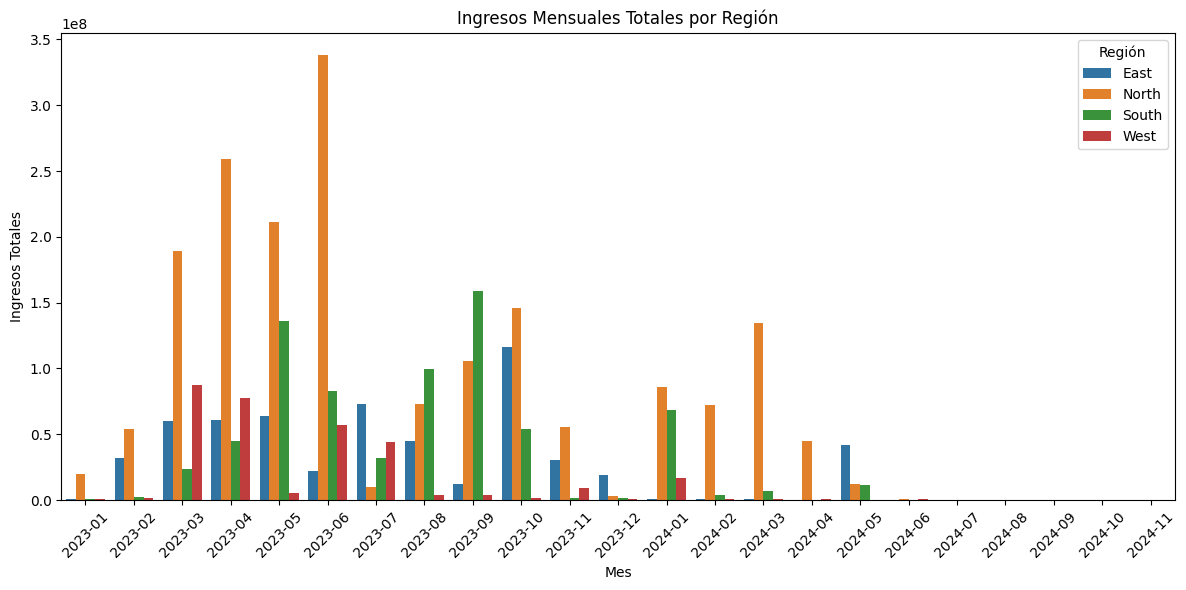

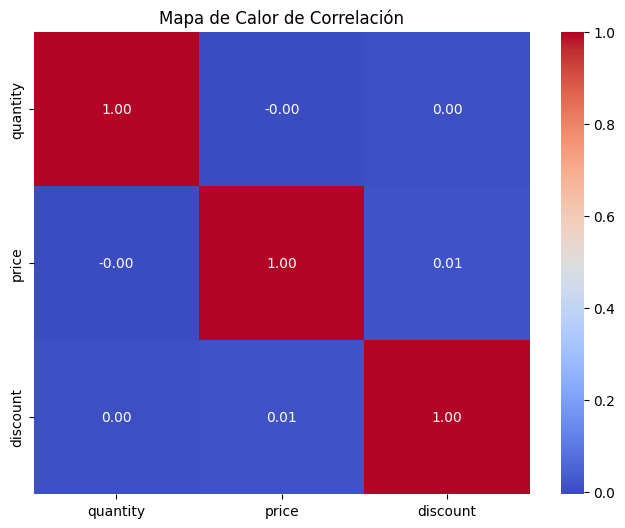

Descripción de Patrones:


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asume que `cleaned_sales_data` ya está cargado.
data = cleaned_sales_data.copy()

# Asegúrate de convertir order_date a formato datetime
data['order_date'] = pd.to_datetime(data['order_date'])

# 1a. Ingresos mensuales totales por región
data['month'] = data['order_date'].dt.to_period('M')
monthly_income = data.groupby(['month', 'region'])['total_income'].sum().reset_index()

# 1b. Top 10 productos con mayores ingresos
data['product_income'] = data['price'] * data['quantity']
top_products = data.groupby('product_id')['product_income'].sum().sort_values(ascending=False).head(10).reset_index()

# 1c. Relación entre prioridad de envío y descuento
shipping_discount = data.groupby('shipping_priority')['discount'].mean().reset_index()

# 2a. Gráfica de barras para ingresos mensuales por región
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_income', hue='region', data=monthly_income)
plt.title('Ingresos Mensuales Totales por Región')
plt.xlabel('Mes')
plt.ylabel('Ingresos Totales')
plt.legend(title='Región')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2b. Mapa de calor de correlación
correlation_matrix = data[['quantity', 'price', 'discount']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación')
plt.show()

# 3. Descripción de patrones
print("Descripción de Patrones:")
# Analiza los resultados observados en los gráficos y tablas generadas.


In [66]:
monthly_income

,month,region,total_income
0,2023-01,East,6.797005e+05
1,2023-01,North,2.009933e+07
2,2023-01,South,9.924693e+05
3,2023-01,West,4.991044e+05
4,2023-02,East,3.166084e+07
...,...,...,...
84,2024-10,East,3.198213e+03
85,2024-10,North,1.171085e+04
86,2024-10,South,1.257285e+04
87,2024-10,West,4.236332e+03


In [67]:
top_products

,product_id,product_income
0,-9999.000000,563621.908330
1,386.397723,447734.963930
2,646.000000,222102.070000
3,404.000000,192224.498358
4,129.000000,191377.069453
5,640.000000,191059.990000
6,634.000000,190906.900000
7,891.000000,186903.630000
8,639.000000,186365.830000
9,964.000000,185902.660000


# Ejercicio 4: Modelado Predictivo

In [68]:
cleaned_sales_data = pd.read_csv('cleaned_sales_data.csv')
cleaned_sales_data.columns

Index(['order_id', 'customer_id', 'product_id', 'quantity', 'price',
       'discount', 'order_date', 'shipping_priority', 'region',
       'total_income'],
      dtype='object')

In [69]:
cleaned_sales_data

,order_id,customer_id,product_id,quantity,price,discount,order_date,shipping_priority,region,total_income
0,e331b5d8-3525-4ba1-a1d2-6034d9d115f5,2692.0,227.0,3.0,466.56,0.00,2023-06-21,High,West,1399.680
1,7782bb1b-0d42-48ac-ab18-348d3b829269,5696.0,124.0,2.0,469.73,0.00,2023-10-01,Medium,North,939.460
2,fcfe8b95-e756-4aaf-bf5e-2f96ef1eda8c,2143.0,335.0,16.0,376.97,0.00,2023-07-30,Low,East,6031.520
3,271e0fe6-4b63-4b52-b95f-c9d6717988c3,9259.0,368.0,12.0,390.75,0.00,2023-10-26,High,North,4689.000
4,1355194b-9dbc-4617-8800-f6b726ca93cb,3236.0,859.0,4.0,280.19,0.00,2023-10-16,Medium,West,1120.760
...,...,...,...,...,...,...,...,...,...,...
48615,9c249d04-5fd0-48b5-bdc1-9c1b2130ac8d,5781.0,524.0,2.0,383.91,0.00,2023-08-13,Medium,North,767.820
48616,e971e88b-6af5-42ba-9729-fbb3dfb5240e,8235.0,846.0,18.0,479.48,0.00,2023-03-06,High,East,8630.640
48617,e4c59e65-8f03-406f-a04a-5d8f3a5a7c8b,185.0,172.0,10.0,450.42,0.00,2023-11-23,Medium,South,4504.200
48618,a0634522-53d1-41eb-9f55-d04b916312d2,9554.0,677.0,20.0,168.06,0.09,2023-06-24,High,North,3058.692


## 1.Carga y visualización inicial de datos:

In [70]:
# Convertir fechas a datetime si aplica
cleaned_sales_data['order_date'] = pd.to_datetime(cleaned_sales_data['order_date'])

# Verificar la estructura de los datos
print(cleaned_sales_data.info())
print(cleaned_sales_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           48411 non-null  object        
 1   customer_id        48620 non-null  float64       
 2   product_id         48620 non-null  float64       
 3   quantity           48620 non-null  float64       
 4   price              48620 non-null  float64       
 5   discount           48620 non-null  float64       
 6   order_date         48384 non-null  datetime64[ns]
 7   shipping_priority  48620 non-null  object        
 8   region             48387 non-null  object        
 9   total_income       48620 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 3.7+ MB
None
        customer_id    product_id      quantity         price      discount  \
count  48620.000000  48620.000000  48620.000000  48620.000000  48620.000000 

# Análisis de estacionalidad y tendencias:

## Genera una serie temporal de ingresos diarios:

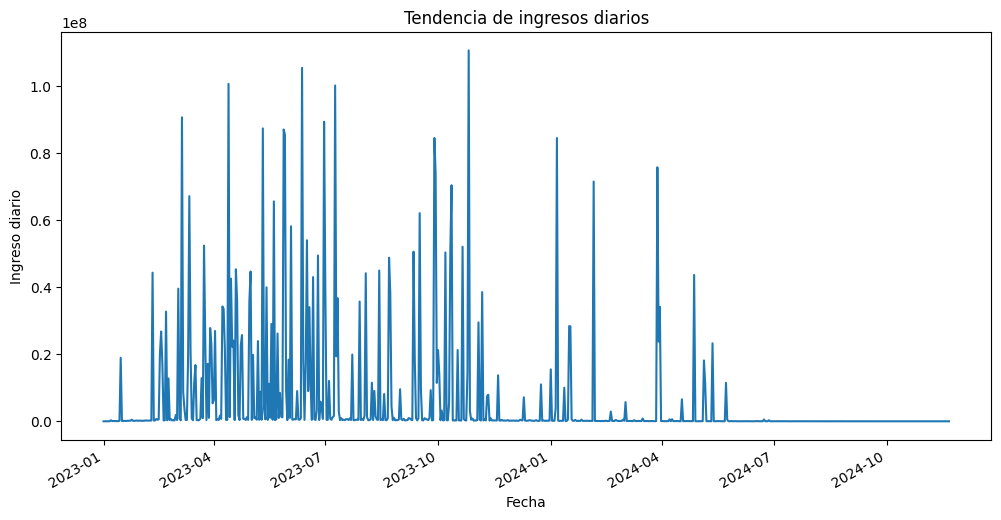

In [72]:
cleaned_sales_data['daily_income'] = cleaned_sales_data['quantity'] * cleaned_sales_data['price'] * (1 - cleaned_sales_data['discount'])
daily_income = cleaned_sales_data.groupby('order_date')['daily_income'].sum()

# Visualización
plt.figure(figsize=(12, 6))
daily_income.plot(title='Tendencia de ingresos diarios', ylabel='Ingreso diario', xlabel='Fecha')
plt.show()


## Descomposición de series temporales (usando statsmodels):

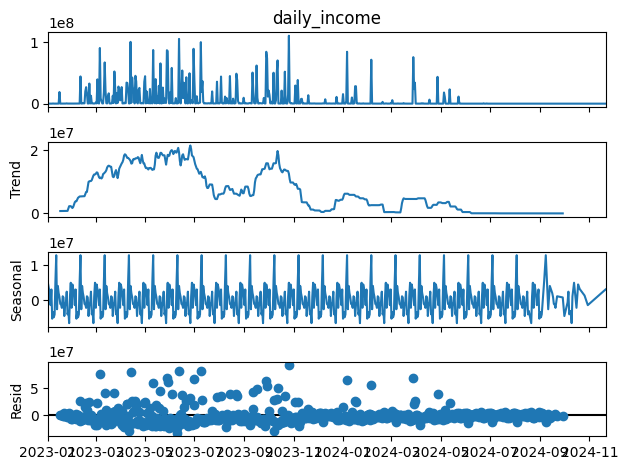

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_income, model='additive', period=30)
decomposition.plot()
plt.show()

# Detecta outliers y evalúa su impacto en las ventas
## Identificar outliers:

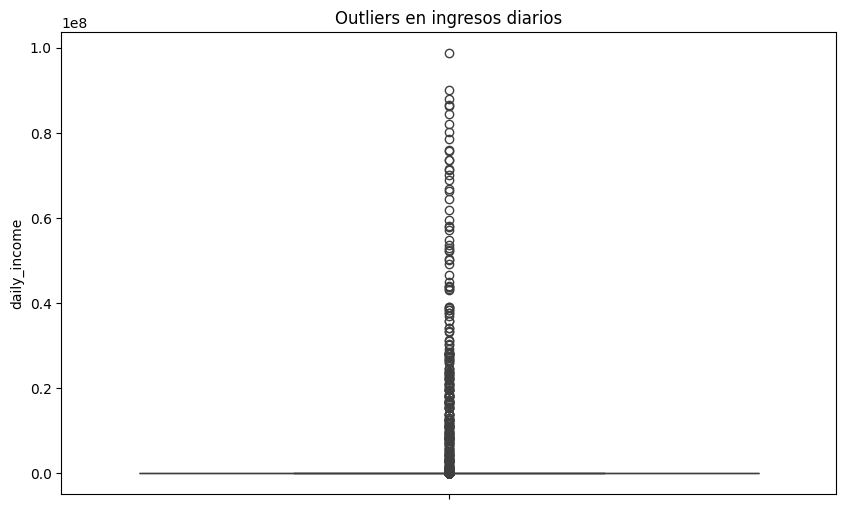

In [76]:
plt.figure(figsize=(10, 6))
sns.boxplot(cleaned_sales_data['daily_income'])
plt.title('Outliers en ingresos diarios')
plt.show()

In [77]:
Q1 = cleaned_sales_data['daily_income'].quantile(0.25)
Q3 = cleaned_sales_data['daily_income'].quantile(0.75)
IQR = Q3 - Q1
outliers = cleaned_sales_data[(cleaned_sales_data['daily_income'] < Q1 - 1.5 * IQR) | (cleaned_sales_data['daily_income'] > Q3 + 1.5 * IQR)]

print(f"Outliers detectados: {len(outliers)}")

Outliers detectados: 852


# Impacto en las ventas:

## Comparar métricas (media, mediana) con y sin outliers:



In [79]:
print("Con outliers:", cleaned_sales_data['daily_income'].mean(), cleaned_sales_data['daily_income'].median())
print("Sin outliers:", cleaned_sales_data[~cleaned_sales_data.index.isin(outliers.index)]['daily_income'].mean(),
      cleaned_sales_data[~cleaned_sales_data.index.isin(outliers.index)]['daily_income'].median())

Con outliers: 115169.88493795016 1953.81
Sin outliers: 2526.0233199394966 1900.33


# 2. Estrategia para predecir el ingreso diario total
## Preparar los datos


In [85]:
from sklearn.model_selection import train_test_split

# Crear variables predictoras (X) y objetivo (y)
cleaned_sales_data['income'] = cleaned_sales_data['quantity'] * cleaned_sales_data['price'] * (1 - cleaned_sales_data['discount'])
X = cleaned_sales_data[['quantity', 'price', 'discount', 'region']]
y = cleaned_sales_data['income']

# Convertir variables categóricas (si aplica)
X = pd.get_dummies(X, columns=['region'], drop_first=True)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Agregar variables temporales como día, mes, día de la semana:

In [86]:
cleaned_sales_data['day'] = cleaned_sales_data['order_date'].dt.day
cleaned_sales_data['month'] = cleaned_sales_data['order_date'].dt.month
cleaned_sales_data['weekday'] = cleaned_sales_data['order_date'].dt.weekday

# Modelos

## Regresión lineal múltiple:



In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Crear modelo y entrenar
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predicciones
y_pred_lr = model_lr.predict(X_test)

# Evaluación
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R^2:", r2_score(y_test, y_pred_lr))


MAE: 166482.49964552964
R^2: 0.5137100423703015


El MAE mide el error promedio absoluto entre los valores reales (y_test) y las predicciones del modelo (y_pred). En promedio, el modelo tiene un error de 166,482.50 unidades monetarias al predecir el ingreso diario total.
El R2 mide qué proporción de la variabilidad en los datos es explicada por el modelo. En este caso el modelo explica aproximadamente el 51.37% de la variabilidad de los ingresos diarios totales observados.

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Random Forest
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Gradient Boosting
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

# Evaluación
print("Random Forest - MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest - R^2:", r2_score(y_test, y_pred_rf))
print("Gradient Boosting - MAE:", mean_absolute_error(y_test, y_pred_gb))
print("Gradient Boosting - R^2:", r2_score(y_test, y_pred_gb))


Random Forest - MAE: 6639.643779310403
Random Forest - R^2: 0.9959789484719392
Gradient Boosting - MAE: 9151.977889019205
Gradient Boosting - R^2: 0.9957882476392599


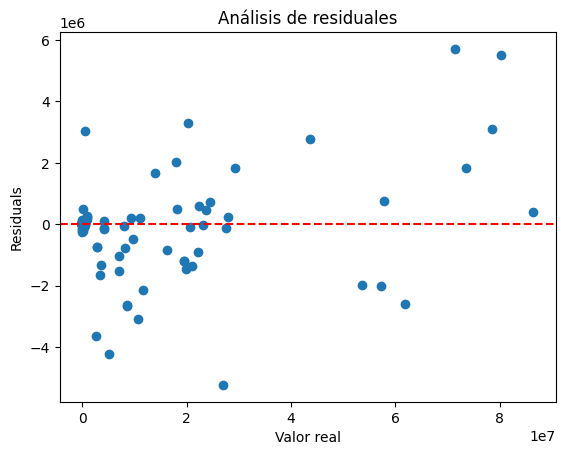

In [89]:
import numpy as np

residuals = y_test - y_pred_gb

# Gráfico de residuales
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Análisis de residuales')
plt.xlabel('Valor real')
plt.ylabel('Residuals')
plt.show()
